## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystops = [EarlyStopping(monitor='val_accuracy',patience=25,verbose=1),EarlyStopping(monitor='val_accuracy',patience=10,verbose=1)]

In [24]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for stop_pace,earlystop in zip((25,10),earlystops):
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train,y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
              validation_data=(x_test,y_test),shuffle=True, callbacks=[earlystop])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    results[f'earlystop in {stop_pace}'] = {'train_loss':train_loss,'valid_loss':valid_loss,
                                           'train_acc':train_acc,'valid_acc':valid_acc}

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512 

50000/50000 [==============================] - 3s 69us/step - loss: 0.5402 - accuracy: 0.8432 - val_loss: 1.6302 - val_accuracy: 0.4903
Epoch 47/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.5232 - accuracy: 0.8484 - val_loss: 1.6545 - val_accuracy: 0.4836
Epoch 48/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.5051 - accuracy: 0.8572 - val_loss: 1.6531 - val_accuracy: 0.4921
Epoch 49/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.4897 - accuracy: 0.8631 - val_loss: 1.6974 - val_accuracy: 0.4824
Epoch 50/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.4737 - accuracy: 0.8704 - val_loss: 1.6847 - val_accuracy: 0.4917
Epoch 00050: early stopping
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_____________________________

In [54]:
color_bar[1]

(1.0, 0.0, 0.16, 1.0)

0
1


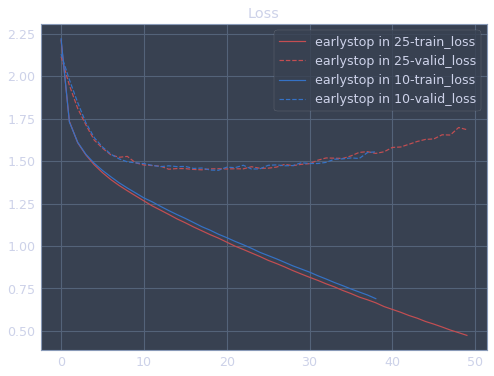

0
1


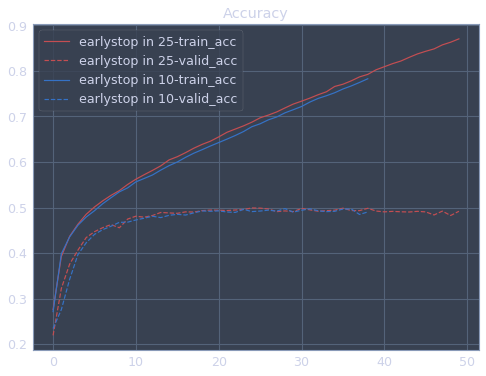

In [58]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

# cm = plt.get_cmap('Paired')
# cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
# scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = ['r','b']


"""Code Here
將結果繪出
"""
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=f'{cond}-train_loss', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=f'{cond}-valid_loss', color=color_bar[i])
    print(i)
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=f'{cond}-train_acc', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=f'{cond}-valid_acc', color=color_bar[i])
    print(i)
plt.title("Accuracy")
plt.legend()
plt.show()

In [59]:
!jupyter nbconvert --to html Day_085_HW.ipynb Day_085_CB_EarlyStop.ipynb

[NbConvertApp] Converting notebook Day_085_HW.ipynb to html
[NbConvertApp] Writing 482447 bytes to Day_085_HW.html
[NbConvertApp] Converting notebook Day_085_CB_EarlyStop.ipynb to html
[NbConvertApp] Writing 408793 bytes to Day_085_CB_EarlyStop.html
